# Setting Up & Familiarizing with the data

In [ ]:
#%% Libraries for data manipulation
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
#plotting
import seaborn as sns
import matplotlib.pyplot as plt 

# data pre-processing libraries
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#%% Libraries for models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

#%% Performance Metrics and Plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# tuning
from sklearn.model_selection import GridSearchCV


: 

In [ ]:
# Load data
rtd=pd.read_csv('Cleaned_Data.csv')
# read few rows
rtd.head()

: 

In [ ]:
#%% Constants
#n = 1 #Number of interations
#n_splits = 10 #Number of slipts in the cross validation

: 

# Cleaning and Organization

## Removing Unwanted Columns

In [ ]:
# object to numeric
# replace nan with ''
# then drop nan
for i in range(5, len(rtd.axes[1])-1):
  if isinstance(rtd.iloc[:,i].dtypes, object):
    rtd.iloc[:,i] = pd.to_numeric(rtd.iloc[:,i], errors='coerce')

#remove nan
rtd.replace('', np.nan, inplace=True)
rtd.dropna(inplace=True, how='any')

rtd_1=rtd.iloc[:,5:len(rtd.axes[1])]

rtd_1.dropna(inplace=True)

: 

In [ ]:
#drop DegreeGPA
rtd_1.drop(['DegreeGPA'], axis=1, inplace=True)

: 

## Treating Missing Observations

In [ ]:
# Convert all 'object' to numeric, remove NAS
cols = rtd_1.columns
rtd_1[cols] = rtd_1[cols].apply(pd.to_numeric, errors='coerce')
rtd_1 = rtd_1.replace(r'^s*$', float('NaN'), regex = True)
rtd_1.dropna(inplace=True)

# missing values in entire data
rtd_1.isnull().sum().sum() # no missing values in the data now

: 

# Exploratory Data Analysis

In [ ]:
# descriptive statistics with dtypes
rtd_1.describe().transpose()

: 

In [ ]:
# correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(rtd_1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=14)

: 

There are some strongly correlated variables with the target variable, but most of the variables are weakly correlated with it. For the highly correlated variables, the plot below was computed, to view the variables clear; correlation coefficient > 0.2 with the target variable.

In [ ]:
# Compute the correlation matrix
corr = rtd_1.corr()

# Select the features with absolute correlation coefficient greater than 0.2 with the target variable
corr_features = corr.index[abs(corr['STEMDegreeCompletion']) > 0.2]

# Compute the correlation matrix of the selected features
corr_selected = rtd_1[corr_features].corr()

# Create a heatmap of the correlation matrix of the selected features
plt.figure(figsize=(12,8))
sns.heatmap(corr_selected, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Significant Features')
plt.show()

: 

In [ ]:
# select columns in rtd_1 that exist in corr_selected
corr_vars = rtd_1[corr_selected.columns]
corr_vars.head()

: 

In [ ]:
# check how the target variables is distributed
print(pd.value_counts(rtd_1['STEMDegreeCompletion']))
sns.countplot(x='STEMDegreeCompletion', data=rtd_1)
plt.title('Target Variable Distribution', fontsize=14)

: 

It is seen that the classes 0 and 1 are unbalanced, and balancing with be necessary

# Pre-processing 

The following will be done:
- scaling the continous variables
- Feature Selection
- Balancing the target variable
- Model selection

## Scaling Continous variables

In [ ]:
# Instanciate StandardScaler 
scaler = MinMaxScaler()

# Select the numerical features to be scaled
num_cols = ['HSGPA', 
            'ACTMath', 
            'ACTEnglish', 
            'EFC', 
            'FamilyIncome', 
            'FirstSemGPA', 
            'FirstYearGPA', 
            'SecondYearGPA', 
            'FirstYrEarnedCreditHours', 
            'SecondYrEarnedCreditHours']

# Scale the numerical features using StandardScaler
rtd_1[num_cols] = scaler.fit_transform(rtd_1[num_cols])
rtd_1.head()

: 

## Feature Selection

**Research Question 1: Which pre-college academic, demographic, and college environment variables/factors serve as significant predicters for students who major in STEM completing a STEM degree?**

From the correlation analysis, we views the most correlated variables with the target, and all were categorical in nature. This poses a limitation of fair selection. `SelectKBest` is used to select features in a fair way. Further, I use logistic regression to check whether the selection is consistent.

### SelectKBest Method

In [ ]:
# Split The Input and output values
X_fs = rtd_1.drop(['STEMDegreeCompletion'], axis=1)
y_fs = rtd_1['STEMDegreeCompletion']

# split the data into train and test
# 70& - 30%
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs, y_fs, test_size=0.3, random_state=2023)

: 

In [ ]:
kbest = SelectKBest(score_func=chi2, k=20) # select top 20 features
X_train_kbest = kbest.fit_transform(X_train_fs, y_train_fs)
X_test_kbest = kbest.transform(X_test_fs)

# Get the selected features
selected_features = X_fs.columns[kbest.get_support()]
print('The Selected Features according to SelectKBest are: ', selected_features)

: 

In [ ]:
# checking with the Logistic Regression method
# Split The Input and output values
X_logit = rtd_1.drop(['STEMDegreeCompletion'], axis=1)
y_logit = rtd_1['STEMDegreeCompletion']

# split the data into train and test
# 70& - 30%
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X_logit, y_logit, test_size=0.3, random_state=2023)

# Train a logistic regression model on the training data
logreg = LogisticRegression()
logreg.fit(X_train_logit, y_train_logit)



# Evaluate the performance of the model on the testing data
y_pred = logreg.predict(X_test_logit)

print('*'*50)
print('Accuracy:', accuracy_score(y_test_logit, y_pred))
print('Precision:', precision_score(y_test_logit, y_pred))
print('Recall:', recall_score(y_test_logit, y_pred))
print('F1 Score:', f1_score(y_test_logit, y_pred))
# logistic regression performs well, and is reliable
print('*'*50)

# Get the feature importances of the logistic regression model
importances = logreg.coef_[0]

# Sort the feature importances in descending order
indices = importances.argsort()[::-1]

# Print the feature importances
for i in range(X_logit.shape[1]):
    print(f'{X_logit.columns[indices[i]]}: {importances[indices[i]]}')

# Plot the feature importances
plt.figure(figsize=(15, 8))
plt.bar(range(X_logit.shape[1]), importances[indices])
plt.xticks(range(X_logit.shape[1]), X_logit.columns[indices], rotation=90)
plt.title('Feature Importances')
plt.show()
# selected Features according to the logistic regression
print('The Selected Features according to Logistic regression are: ', X_logit.columns[indices])

: 

: 

From the two operations above, we see that these variables are the top 15 in feature importance in predicting `STEMDegreeCompletion`:
- DegreeGPA
- HSGPA
- ACTMath
- ACTEnglish
- Gender
- First_Gen
- EFC
- CampHousing
- Greek
- FirstSemGPA
- FirstYearGPA
- SecondYearGPA
- FirstYrCalcorHigherCompletion
- FirstYrStEMRetention
- SecondYrSTEMRetention
- FirstYrEarnedCreditHours

In [ ]:
selected_feats = ['HSGPA', 
                  'ACTMath', 
                  'ACTEnglish', 
                  'Gender', 
                  'First_Gen', 
                  'EFC', 
                  'CampHousing', 
                  'Greek', 
                  'FirstSemGPA', 
                  'FirstYearGPA', 
                  'SecondYearGPA', 
                  'FirstYrCalcorHigherCompletion', 
                  'FirstYrStEMRetention', 
                  'SecondYrSTEMRetention', 
                  'FirstYrEarnedCreditHours']

X = rtd_1[selected_feats]
y = rtd_1['STEMDegreeCompletion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

: 

## Balancing the Target

In [ ]:
# Instantiate a RandomUnderSampler object to balance the classes
rus = RandomUnderSampler(random_state=42)
# Undersample the majority class
X_rus, y_rus = rus.fit_resample(X, y)

# Instantiate a RandomOverSampler object to balance the classes
ros = RandomOverSampler(random_state=42)
# Oversample the minority class
X_res, y_res = ros.fit_resample(X_rus, y_rus)

# Create a new dataframe with the resampled data
rtd_res = pd.concat([X_res, y_res], axis=1)

# plot the balanced target variable
sns.barplot(x='STEMDegreeCompletion', y='STEMDegreeCompletion', data=rtd_res, estimator=lambda x: len(x) / len(rtd_res) * 100)

: 

# Modelling

**Research Question 2: What are the classification accuracy of five supervised machine learning classification algorithms in predicting degree completion of STEM majors: adaptive boosting (ADB), classification & regression trees (CART), random forest (RF), support vector machine (SVM), and extreme gradient boosting (XGB)?** 

## Training

In [230]:

# Train and evaluate the ADB classifier
adb = AdaBoostClassifier(random_state=2023)
adb.fit(X_train, y_train)
adb_pred = adb.predict(X_test)
adb_acc = accuracy_score(y_test, adb_pred)

# Train and evaluate the CART classifier
cart = DecisionTreeClassifier(random_state=2023)
cart.fit(X_train, y_train)
cart_pred = cart.predict(X_test)
cart_acc = accuracy_score(y_test, cart_pred)

# Train and evaluate the Logistic Regression classifier
lr = LogisticRegression(random_state=2023)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)

# Train and evaluate the RF classifier
rf = RandomForestClassifier(random_state=2023)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Train and evaluate the SVM classifier
svm = SVC(random_state=2023)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

# Train and evaluate the XGB classifier
xgb = XGBClassifier(random_state=2023)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)

## Evaluation

In [231]:

# Print the classification accuracies of the five classifier * 100s
print("ADB Accuracy", round(adb_acc * 100, 2), '%')
print("CART Accuracy", round(cart_acc * 100, 2), '%')
print("LR Accuracy", round(lr_acc * 100, 2), '%')
print("RF Accuracy", round(rf_acc * 100, 2), '%')
print("SVM Accuracy", round(svm_acc * 100, 2), '%')
print("XGB Accuracy", round(xgb_acc * 100, 2), '%')


ADB Accuracy 88.38 %
CART Accuracy 83.26 %
LR Accuracy 88.93 %
RF Accuracy 89.07 %
SVM Accuracy 88.93 %
XGB Accuracy 88.8 %


Random Forest and SVM both have the highest accuracies at 89.76%.

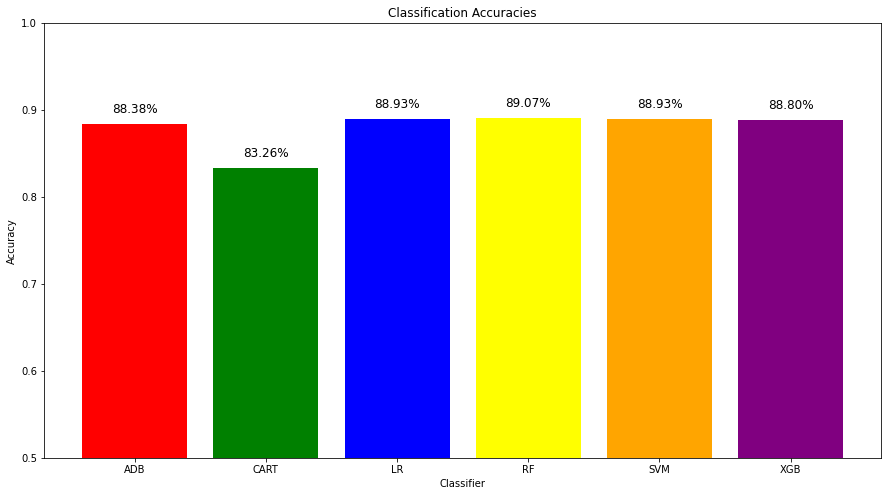

In [234]:
# Define the classifier names and accuracies
classifier_names = ['ADB', 'CART', 'LR', 'RF', 'SVM', 'XGB']
accuracies = [adb_acc, cart_acc, lr_acc, rf_acc, svm_acc, xgb_acc]

# Create a bar plot of the classifier accuracies
plt.figure(figsize=(15, 8))
plt.bar(classifier_names, accuracies, color=['red', 'green', 'blue', 'yellow', 'orange', 'purple'])
plt.ylim([0.5, 1])
plt.title('Classification Accuracies')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
# Annotate the bars with the accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.01, f'{acc*100:.2f}%', ha='center', va='bottom', fontdict={'size': 12})

plt.show()


In [240]:

# Finding out the different accuracies for each classifier, at different training sizes
# Define the classifiers
classifiers = [
    ('ADB', AdaBoostClassifier(random_state=2023)),
    ('CART', DecisionTreeClassifier(random_state=2023)),
    ('LR', LogisticRegression(random_state=2023)),
    ('RF', RandomForestClassifier(random_state=2023)),
    ('SVM', SVC(random_state=2023, probability=True)),
    ('XGB', XGBClassifier(random_state=2023))
]

# Define the train sizes to test
train_sizes = np.linspace(0.1, 0.9, num=9)

# Train each classifier on different proportions of the training data and record the accuracy scores
accuracy_scores = {name: [] for name, _ in classifiers}
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=2023)
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_scores[name].append(acc)

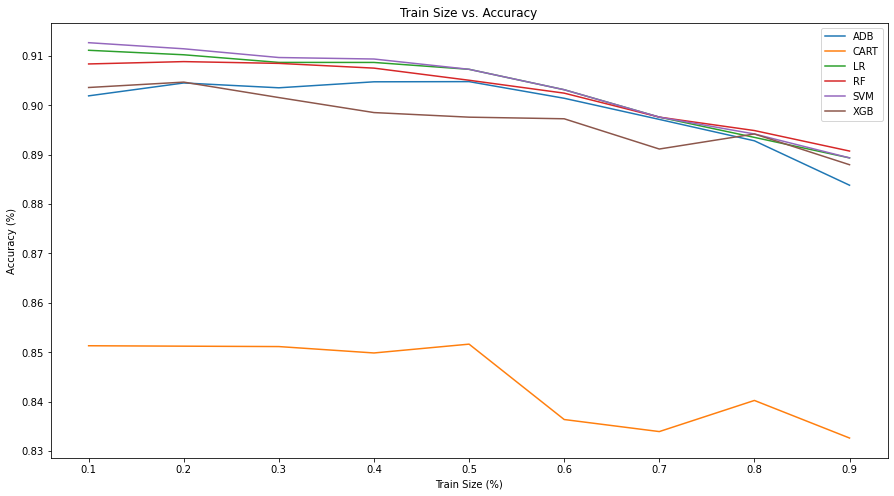

In [241]:
# Create a line plot of train size vs. accuracy for each classifier
plt.figure(figsize=(15, 8))
for name, _ in classifiers:
    plt.plot(train_sizes, accuracy_scores[name], label=name)

plt.title('Train Size vs. Accuracy')
plt.xlabel('Train Size (%)')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

**Research Question 3: Which machine learning algorithm have the superior evaluation metrics in predicting degree completion of STEM majors; adaptive boosting (ADB), classification & regression trees (CART), logistic regression (LR), random forest (RF), support vector machine (SVM), and extreme gradient boosting (XGB)?**  

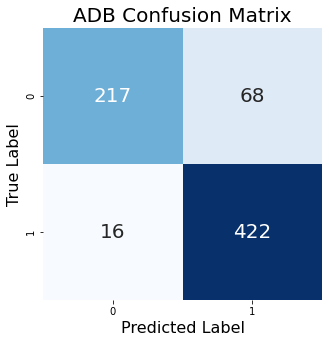

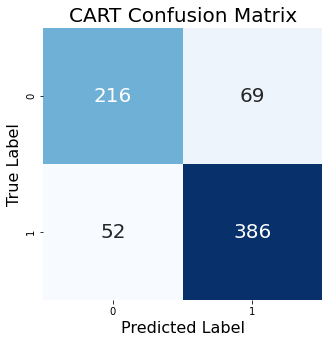

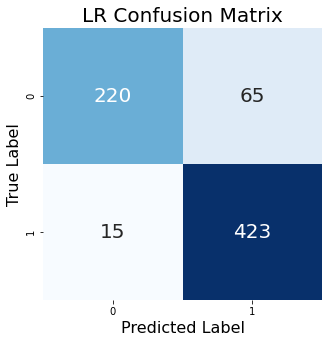

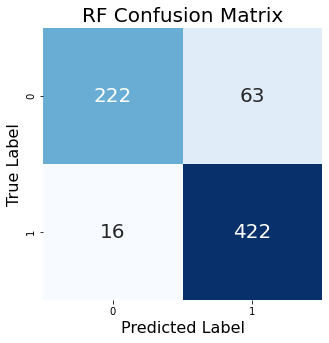

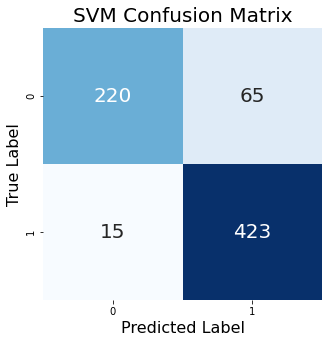

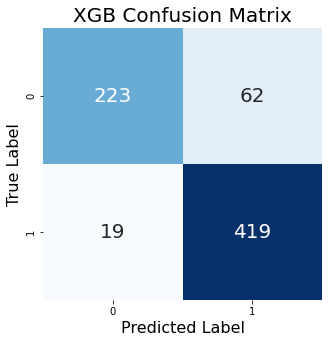

In [237]:
# Define the list of classifiers and their corresponding models
classifiers = ['ADB', 'CART', 'LR', 'RF', 'SVM', 'XGB']
models = [adb, cart, lr, rf, svm, xgb] # Assuming these models have already been trained and evaluated

# Loop over the classifiers and generate the confusion matrix for each
for i, clf in enumerate(models):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 20})
    plt.title(f"{classifiers[i]} Confusion Matrix", fontsize=20)
    plt.xlabel("Predicted Label", fontsize=16)
    plt.ylabel("True Label", fontsize=16)
    plt.show()

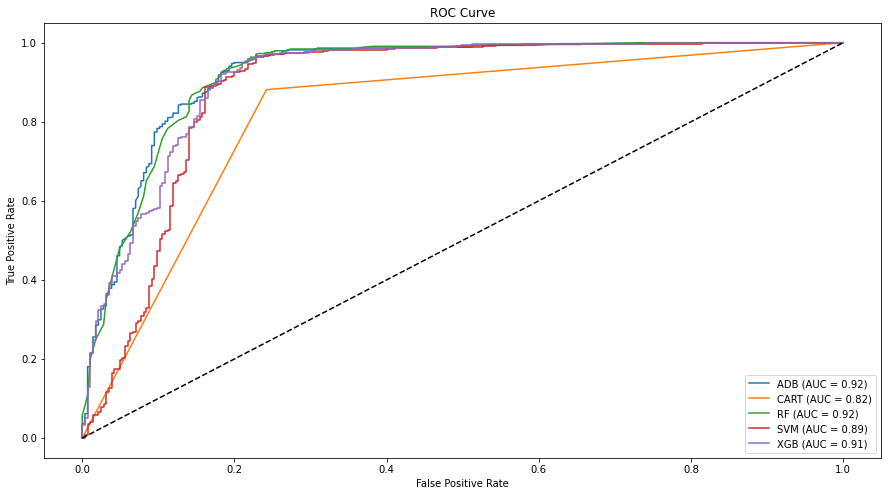

In [105]:
# Plot the ROC curve for each classifier
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(15, 8))
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

In [111]:
# Compute classification report for each classifier
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{name}\n{classification_report(y_test, y_pred)}')

ADB
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       285
           1       0.86      0.96      0.91       438

    accuracy                           0.88       723
   macro avg       0.90      0.86      0.87       723
weighted avg       0.89      0.88      0.88       723

CART
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       285
           1       0.85      0.88      0.86       438

    accuracy                           0.83       723
   macro avg       0.83      0.82      0.82       723
weighted avg       0.83      0.83      0.83       723

RF
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       285
           1       0.87      0.96      0.91       438

    accuracy                           0.89       723
   macro avg       0.90      0.87      0.88       723
weighted avg       0.89      0.89      0.89       723

SVM
   

In [ ]:
reports = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append((name, report['accuracy'], report['1']['precision'], report['1']['recall'], report['1']['f1-score']))

# Create a pandas dataframe with the classification reports
df_report = pd.DataFrame(reports, columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

In [114]:
# Print the dataframe
df_report

,Algorithm,Accuracy,Precision,Recall,F1-score
0,ADB,0.883817,0.861224,0.963470,0.909483
1,CART,0.832642,0.848352,0.881279,0.864502
2,RF,0.890733,0.870103,0.963470,0.914410
3,SVM,0.889350,0.866803,0.965753,0.913607
4,XGB,0.887967,0.871102,0.956621,0.911861


Random Forest is superior

## Optimization

In [263]:
# use gridsearch
parameter_grid = [{
        # ADB
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    {
        # CART
        'max_depth': [3,5,10],
        'min_samples_split': [2,5,10]
     },
    {
        # LR
        'max_iter': [100, 200, 300]
    },
    {
        # RF
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],        
    },
    {
        # SVM
        'C': [0.01, 0.1, 1.0],
        'gamma': [0.01, 0.1, 1.0],
        # kernels: sigmoid, rbf, poly, linear
        'kernel': ['rbf']
    },
    {
        # XGB
        'n_estimators': [50, 100, 200],
        'max_depth': [3,5,10]
    }
]

In [264]:
# do GridSearch to find the best parameters for optimized model
for i, (name, clf) in enumerate(classifiers):
        grid_search = GridSearchCV(clf, parameter_grid[i], cv=5, scoring = 'accuracy')
        grid_search.fit(X, y)
        #print the grid searh results
        print(f'{name}:\nBest parameters: {grid_search.best_params_}\nBest score: {grid_search.best_score_:.2f}\n')


ADB:
Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
Best score: 0.91

CART:
Best parameters: {'max_depth': 3, 'min_samples_split': 2}
Best score: 0.91

LR:
Best parameters: {'max_iter': 100}
Best score: 0.91

RF:
Best parameters: {'criterion': 'entropy', 'n_estimators': 100}
Best score: 0.91

SVM:
Best parameters: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.91

XGB:
Best parameters: {'max_depth': 3, 'n_estimators': 50}
Best score: 0.91



In [268]:

# Train and evaluate the ADB classifier
adb = AdaBoostClassifier(random_state=2023, algorithm='SAMME.R', learning_rate=0.1, n_estimators=100)
adb.fit(X_train, y_train)
adb_pred = adb.predict(X_test)
adb_acc = accuracy_score(y_test, adb_pred)

# Train and evaluate the CART classifier
cart = DecisionTreeClassifier(random_state=2023, max_depth=3, min_samples_split=2)
cart.fit(X_train, y_train)
cart_pred = cart.predict(X_test)
cart_acc = accuracy_score(y_test, cart_pred)

# Train and evaluate the Logistic Regression classifier
lr = LogisticRegression(random_state=2023, max_iter=100)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)

# Train and evaluate the RF classifier
rf = RandomForestClassifier(random_state=2023, criterion='entropy', n_estimators=100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Train and evaluate the SVM classifier
svm = SVC(random_state=2023, C=1.0, gamma=0.01, kernel='rbf')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

# Train and evaluate the XGB classifier
xgb = XGBClassifier(random_state=2023, max_depth=3, n_estimators=50)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)

In [270]:

# Print the classification accuracies of the five classifier * 100s
print("ADB Accuracy", round(adb_acc * 100, 2), '%')
print("CART Accuracy", round(cart_acc * 100, 2), '%')
print("LR Accuracy", round(lr_acc * 100, 2), '%')
print("RF Accuracy", round(rf_acc * 100, 2), '%')
print("SVM Accuracy", round(svm_acc * 100, 2), '%')
print("XGB Accuracy", round(xgb_acc * 100, 2), '%')


ADB Accuracy 89.07 %
CART Accuracy 88.93 %
LR Accuracy 88.93 %
RF Accuracy 89.21 %
SVM Accuracy 88.93 %
XGB Accuracy 88.66 %


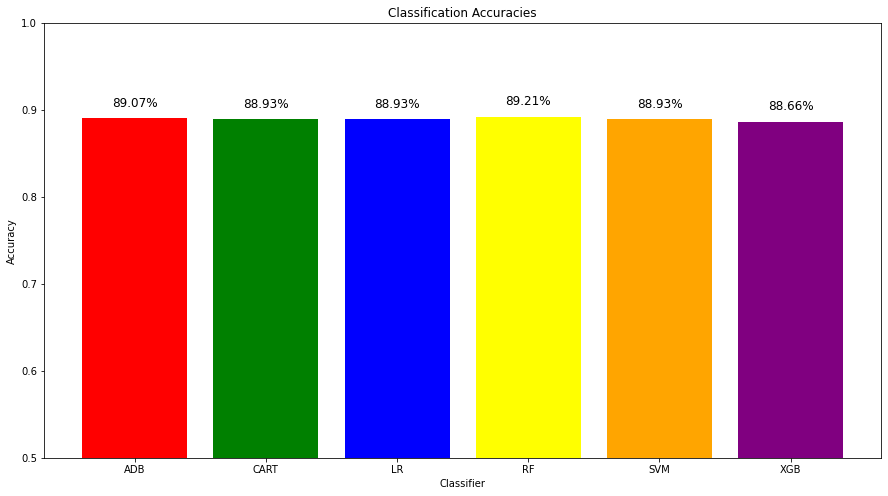

In [271]:
# Define the classifier names and accuracies
classifier_names = ['ADB', 'CART', 'LR', 'RF', 'SVM', 'XGB']
accuracies = [adb_acc, cart_acc, lr_acc, rf_acc, svm_acc, xgb_acc]

# Create a bar plot of the classifier accuracies
plt.figure(figsize=(15, 8))
plt.bar(classifier_names, accuracies, color=['red', 'green', 'blue', 'yellow', 'orange', 'purple'])
plt.ylim([0.5, 1])
plt.title('Classification Accuracies with Opitimzed Parameters')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
# Annotate the bars with the accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.01, f'{acc*100:.2f}%', ha='center', va='bottom', fontdict={'size': 12})

plt.show()


In [279]:

# Finding out the different accuracies for each classifier, at different training sizes
# Define the classifiers
classifiers = [
    ('ADB', AdaBoostClassifier(random_state=2023)),
    ('CART', DecisionTreeClassifier(random_state=2023)),
    ('LR', LogisticRegression(random_state=2023)),
    ('RF', RandomForestClassifier(random_state=2023)),
    ('SVM', SVC(random_state=2023, probability=True)),
    ('XGB', XGBClassifier(random_state=2023))
]

# Define the train sizes to test
train_sizes = np.linspace(0.1, 0.9, num=9)

# Train each classifier on different proportions of the training data and record the accuracy scores
accuracy_scores = {name: [] for name, _ in classifiers}
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=2023)
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_scores[name].append(acc)

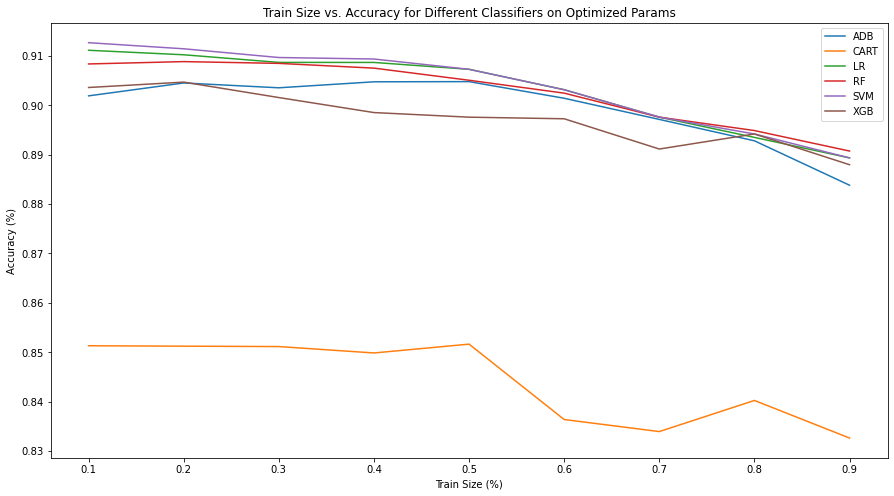

In [280]:
# Create a line plot of train size vs. accuracy for each classifier
plt.figure(figsize=(15, 8))
for name, _ in classifiers:
    plt.plot(train_sizes, accuracy_scores[name], label=name)

plt.title('Train Size vs. Accuracy')
plt.xlabel('Train Size (%)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train Size vs. Accuracy for Different Classifiers on Optimized Params')
plt.show()

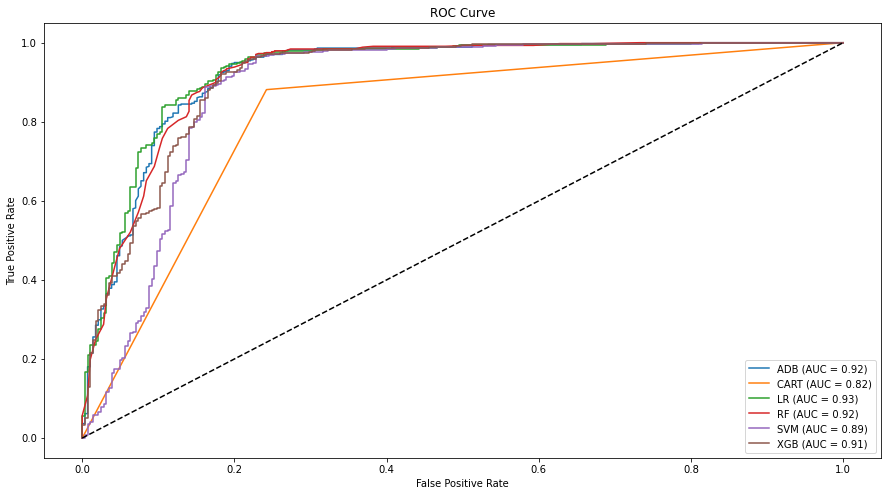

In [281]:
# Plot the ROC curve for each classifier
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(15, 8))
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

In [282]:
# Compute classification report for each classifier
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{name}\n{classification_report(y_test, y_pred)}')

ADB
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       285
           1       0.86      0.96      0.91       438

    accuracy                           0.88       723
   macro avg       0.90      0.86      0.87       723
weighted avg       0.89      0.88      0.88       723

CART
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       285
           1       0.85      0.88      0.86       438

    accuracy                           0.83       723
   macro avg       0.83      0.82      0.82       723
weighted avg       0.83      0.83      0.83       723

LR
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       285
           1       0.87      0.97      0.91       438

    accuracy                           0.89       723
   macro avg       0.90      0.87      0.88       723
weighted avg       0.89      0.89      0.89       723

RF
    

In [283]:
reports = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append((name, report['accuracy'], report['1']['precision'], report['1']['recall'], report['1']['f1-score']))

# Create a pandas dataframe with the classification reports
df_report = pd.DataFrame(reports, columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

In [284]:
# Print the dataframe
df_report

,Algorithm,Accuracy,Precision,Recall,F1-score
0,ADB,0.883817,0.861224,0.963470,0.909483
1,CART,0.832642,0.848352,0.881279,0.864502
2,LR,0.889350,0.866803,0.965753,0.913607
3,RF,0.890733,0.870103,0.963470,0.914410
4,SVM,0.889350,0.866803,0.965753,0.913607
5,XGB,0.887967,0.871102,0.956621,0.911861


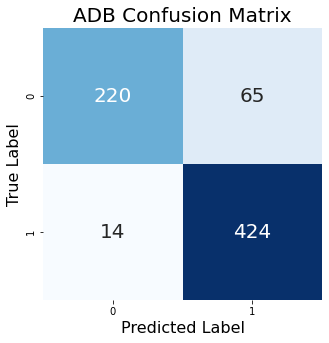

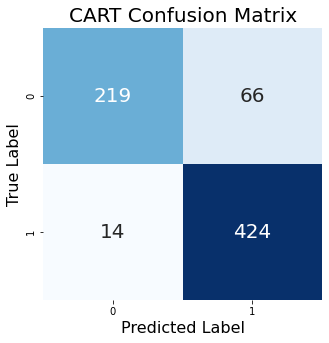

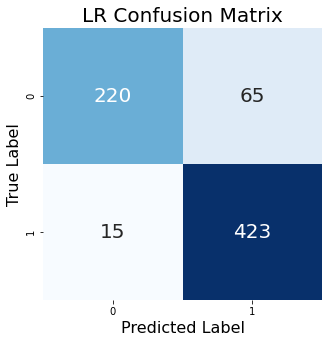

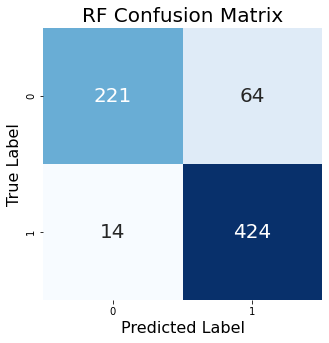

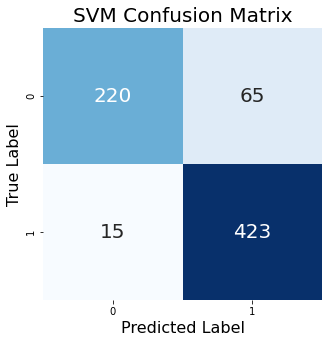

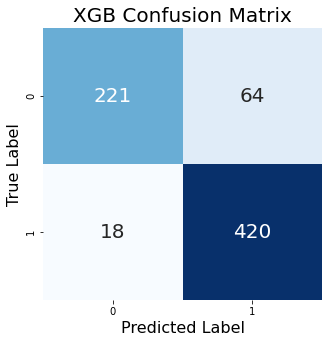

In [285]:
# Define the list of classifiers and their corresponding models
classifiers = ['ADB', 'CART', 'LR', 'RF', 'SVM', 'XGB']
models = [adb, cart, lr, rf, svm, xgb] # Assuming these models have already been trained and evaluated

# Loop over the classifiers and generate the confusion matrix for each
for i, clf in enumerate(models):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 20})
    plt.title(f"{classifiers[i]} Confusion Matrix", fontsize=20)
    plt.xlabel("Predicted Label", fontsize=16)
    plt.ylabel("True Label", fontsize=16)
    plt.show()